## Train a supervised baseline on the datasplits
We train an equivalent model on the long-tailed datasets and measure the accuracies as well.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from data.data import SupervisedImbalanceCIFAR10_index, SupervisedImbalanceCIFAR100_index, get_transforms
from utils import AverageMeter
import argparse
import os
import numpy as np
from collections import defaultdict

data_dir = '../datasets'
dataset = 'cifar10'
optimizer = 'sgd'
lr = 0.5
batch_size = 512
split = 3
rho = 100 # Imbalance ratio
epochs = 182
weight_decay = 1e-5

In [31]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_augs, _ = get_transforms()
print(train_augs)
test_augs = transforms.ToTensor()
if dataset == 'cifar10':
    train_dataset = SupervisedImbalanceCIFAR10_index(root=data_dir,train=True, transform=train_augs, 
                                       split_num=split, imb_ratio=rho)
    test_dataset = datasets.CIFAR10(root=data_dir, train=False, transform=test_augs)
    num_classes = 10 
elif dataset == 'cifar100':
    train_dataset = SupervisedImbalanceCIFAR100_index(root=data_dir, train=True, transform=train_augs,
                                           split_num=split, imb_ratio=rho)
    test_dataset = datasets.CIFAR100(root=data_dir, train=False, transform=test_augs, download=False)
    num_classes = 100

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = models.resnet18(num_classes=num_classes)
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr , weight_decay=1e-5) if optimizer == 'adam' else optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_dataset))
criterion = nn.CrossEntropyLoss().to(device)

Compose(
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    Compose(
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=[-0.1, 0.1])
)
    RandomGrayscale(p=0.2)
)
    ToTensor()
)
Loading splits/cifar10_split1_imbfac100
Loading splits/cifar100_split3_imbfac100
Loading splits/cifar100_split3_imbfac100


In [22]:
dist = train_dataset.get_sample_dist()
print(dist)
for classid, _ in sorted(dist.items(), key=lambda x: x[1], reverse=True):
    print(f'{classid}: {testClassAccs[classid]}')

{0: 14, 1: 70, 2: 415, 3: 81, 4: 171, 5: 328, 6: 46, 7: 6, 8: 18, 9: 93, 10: 7, 11: 6, 12: 40, 13: 123, 14: 85, 15: 89, 16: 6, 17: 273, 18: 30, 19: 156, 20: 179, 21: 24, 22: 29, 23: 7, 24: 129, 25: 477, 26: 248, 27: 226, 28: 344, 29: 13, 30: 188, 31: 58, 32: 32, 33: 44, 34: 36, 35: 455, 36: 77, 37: 102, 38: 163, 39: 286, 40: 135, 41: 314, 42: 237, 43: 396, 44: 12, 45: 5, 46: 35, 47: 74, 48: 6, 49: 8, 50: 56, 51: 13, 52: 500, 53: 206, 54: 5, 55: 10, 56: 112, 57: 22, 58: 21, 59: 33, 60: 8, 61: 42, 62: 67, 63: 149, 64: 38, 65: 11, 66: 107, 67: 20, 68: 16, 69: 197, 70: 17, 71: 299, 72: 25, 73: 11, 74: 260, 75: 9, 76: 15, 77: 361, 78: 26, 79: 61, 80: 51, 81: 434, 82: 48, 83: 378, 84: 27, 85: 9, 86: 118, 87: 7, 88: 53, 89: 64, 90: 23, 91: 142, 92: 98, 93: 5, 94: 12, 95: 19, 96: 5, 97: 15, 98: 216, 99: 10}
52: 0.28
25: 0.11
35: 0.0
81: 0.51
2: 0.11
43: 0.52
83: 0.51
77: 0.0
28: 0.19
5: 0.44
41: 0.34
71: 0.81
39: 0.26
17: 0.19
74: 0.01
26: 0.0
42: 0.01
27: 0.0
98: 0.0
53: 0.52
69: 0.73
30: 0.0

In [32]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


cumTestAccs = defaultdict(list)
imgs_per_class = len(test_loader.dataset) / num_classes
def print_category_accs():
    pass
for epoch in range(0, epochs):
    model.train()
    trainTop1 = AverageMeter('Train Top 1')
    lossMeter = AverageMeter('Loss')
    testTop1 = AverageMeter('Test Top 1')
    testTop5 = AverageMeter('Test top 1')
    testClassAccs = defaultdict(int) #Per class testing accs per epoch
    for i, (x, targets) in enumerate(train_loader):
        x = x.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, targets)
        lossMeter.update(loss.item())
        top1 = accuracy(logits, targets)[0].item()
        trainTop1.update(top1)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    model.eval()
    
    with torch.no_grad():
        for i, (x, targets) in enumerate(test_loader):
            x = x.to(device)
            targets = targets.to(device)
            logits = model(x)
            top1, top5 = accuracy(logits, targets, topk=(1, 5))
            
            testTop1.update(top1.item())
            testTop5.update(top5.item())

            # Record per-class accuracies
            preds = torch.argmax(logits, dim=1)
            for j in range(targets.shape[0]):
                if preds[j].item() == targets[j].item():
                    testClassAccs[targets[j].item()] += 1
        print(f'Epoch {epoch} Loss: {lossMeter.avg:.4f}, Train Top1: {trainTop1.avg:.4f} Test Top 1: {testTop1.avg:.4f} Test Top 5: {testTop5.avg}')

        # Record per-class accuracies
        for classid in range(num_classes):
            if classid not in testClassAccs:
                #print(f"{classid} not found this epoch :(")
                testClassAccs[classid] = 0
            testClassAccs[classid] /= imgs_per_class
            cumTestAccs[classid].append(testClassAccs[classid])
        #print(testClassAccs)

Epoch 0 Loss: 5.3056, Train Top1: 4.1262 Test Top 1: 1.0782 Test Top 5: 5.56640625
Epoch 1 Loss: 4.1128, Train Top1: 4.8345 Test Top 1: 1.5165 Test Top 5: 6.402803301811218
Epoch 2 Loss: 4.0103, Train Top1: 5.2039 Test Top 1: 1.4689 Test Top 5: 6.4453125
Epoch 3 Loss: 3.9809, Train Top1: 5.3760 Test Top 1: 1.4861 Test Top 5: 7.238051462173462
Epoch 4 Loss: 3.9381, Train Top1: 6.2476 Test Top 1: 1.7348 Test Top 5: 7.794692087173462
Epoch 5 Loss: 3.9137, Train Top1: 6.8690 Test Top 1: 2.1036 Test Top 5: 8.648897051811218
Epoch 6 Loss: 3.8862, Train Top1: 7.1782 Test Top 1: 1.9083 Test Top 5: 9.52378215789795
Epoch 7 Loss: 3.8572, Train Top1: 7.6912 Test Top 1: 2.1978 Test Top 5: 9.071691179275513
Epoch 8 Loss: 3.8438, Train Top1: 8.2185 Test Top 1: 2.6178 Test Top 5: 9.60190715789795
Epoch 9 Loss: 3.8339, Train Top1: 8.0942 Test Top 1: 2.3989 Test Top 5: 9.169921875
Epoch 10 Loss: 3.8293, Train Top1: 8.2185 Test Top 1: 2.4810 Test Top 5: 9.180261945724487
Epoch 11 Loss: 3.8203, Train Top

Epoch 90 Loss: 2.8347, Train Top1: 29.1954 Test Top 1: 12.7298 Test Top 5: 31.901999092102052
Epoch 91 Loss: 2.8149, Train Top1: 30.4896 Test Top 1: 15.7571 Test Top 5: 35.457261085510254
Epoch 92 Loss: 2.8037, Train Top1: 30.4398 Test Top 1: 17.1456 Test Top 5: 37.46323528289795
Epoch 93 Loss: 2.8012, Train Top1: 30.9103 Test Top 1: 14.1872 Test Top 5: 34.2957260131836
Epoch 94 Loss: 2.7605, Train Top1: 31.8011 Test Top 1: 17.0180 Test Top 5: 36.704388809204104
Epoch 95 Loss: 2.7397, Train Top1: 31.7562 Test Top 1: 15.7031 Test Top 5: 35.302734375
Epoch 96 Loss: 2.7509, Train Top1: 31.8810 Test Top 1: 17.4925 Test Top 5: 37.34145221710205
Epoch 97 Loss: 2.7294, Train Top1: 32.5754 Test Top 1: 16.7739 Test Top 5: 37.78033084869385
Epoch 98 Loss: 2.7138, Train Top1: 32.5182 Test Top 1: 18.8132 Test Top 5: 39.94485282897949
Epoch 99 Loss: 2.7172, Train Top1: 32.4827 Test Top 1: 18.1135 Test Top 5: 39.3738510131836
Epoch 100 Loss: 2.6744, Train Top1: 33.5106 Test Top 1: 18.2175 Test Top 5

Epoch 178 Loss: 1.8410, Train Top1: 51.8380 Test Top 1: 27.6528 Test Top 5: 53.4375
Epoch 179 Loss: 1.8148, Train Top1: 52.7475 Test Top 1: 28.3519 Test Top 5: 55.248736190795896
Epoch 180 Loss: 1.8158, Train Top1: 52.6414 Test Top 1: 26.5941 Test Top 5: 53.17612590789795
Epoch 181 Loss: 1.7953, Train Top1: 52.8945 Test Top 1: 28.7006 Test Top 5: 55.43198528289795


### Keep track of the accuracies
However, instead of listing the accuracies in the order of class (e.g. Class0 "Truck"...) we list them by descending order of sample count

|Model |dist|Total| Many | Medium | Few | c0 | c1 | c2 | c3 | c4 | c5 | c6 | c7 | c8 | c9
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|resnet18|1|63.45|93.4|72.8|20.1|96.1|92.5|91.6|95.3|92.2|48.8|54.9|35.0|24.9|4.0|
|resnet18|2|66.7997|92.4|75.0|29.9|98.3|89.1|89.9|93.6|66.1|64.5|75.8|66.8|12.8|10.1|
|resnet18|3|64.2854|94.0|59.95|40.2|98.5|89.7|93.8|57.8|54.1|54.8|73.1|44.6|46.8|29.2|

For CIFAR100-LT, we have the following

|Model|dist|Many|Medium|Few|Total|
|:---:|:---:|:---:|:---:|:---:|:---:|
resnet18|1|58.03|21.74|6.18|28.58|
resnet18|2|55.61|24.47|7.61|29.18|
resnet18|3|56.55|24.03|5.7|28.7|

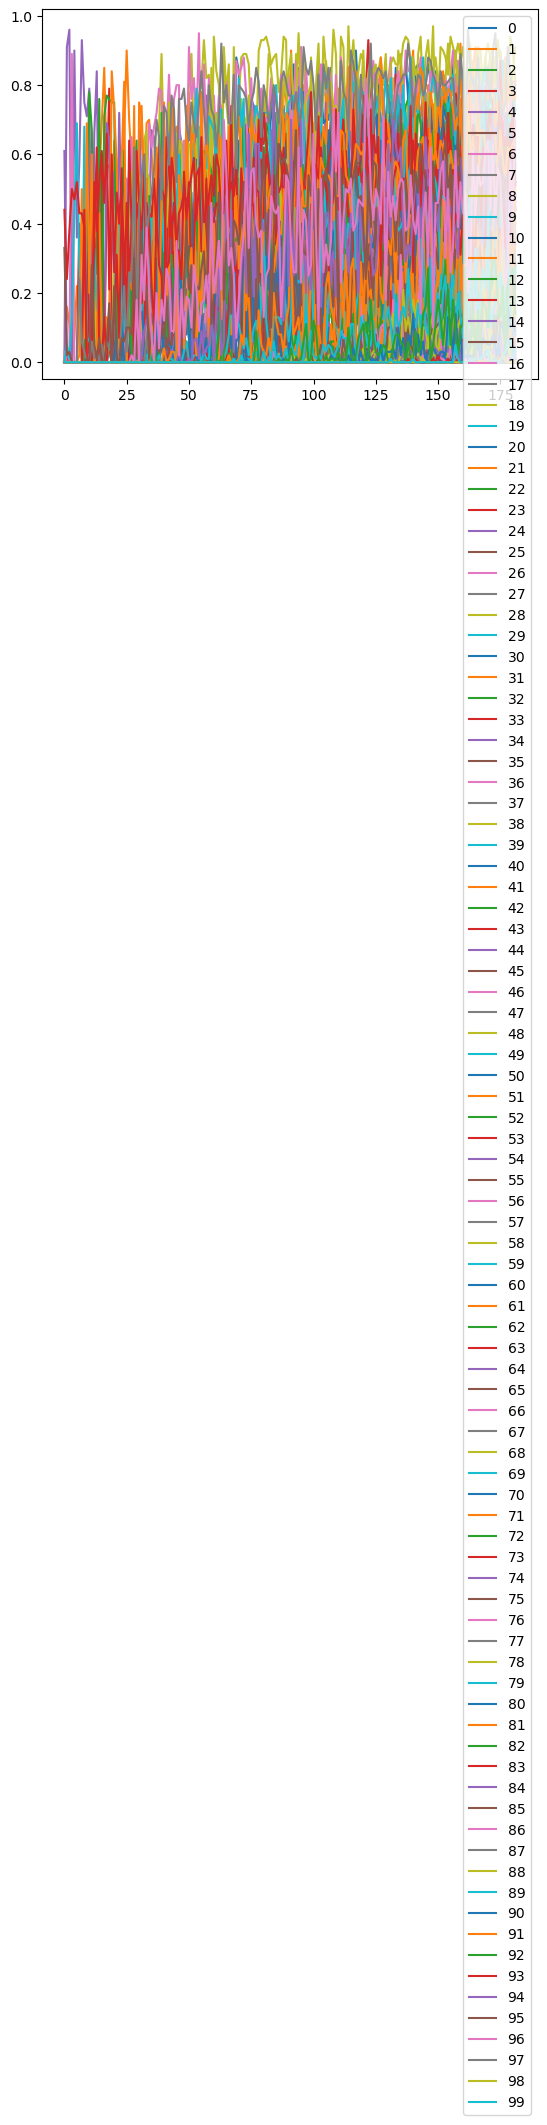

In [10]:
for classid, accs in cumTestAccs.items():
    plt.plot(accs, label=classid)
plt.legend()
plt.show()

In [33]:
def get_class_dist(split=1):
    filename = f'splits/cifar{num_classes}_split{split}_imbfac{rho}'
    targets = np.load(f'{filename}_targets.npy')
    sample_counts = np.bincount(np.array(targets))
    sample_dict = {}
    for i in range(num_classes):
        sample_dict[i] = sample_counts[i]
    return sample_dict
dist = get_class_dist(split=split)
print(dist)
intervals = [0, 33, 67, 100]

many, medium, few = 0, 0, 0
manycount, mediumcount, fewcount = 0, 0, 0
for i, (classid, _) in enumerate(sorted(dist.items(), key=lambda x:x[1], reverse=True)):
    if i >= intervals[0] and i < intervals[1]:
        many += testClassAccs[classid]
        manycount += 1
    elif i >= intervals[1] and i < intervals[2]:
        medium += testClassAccs[classid]
        mediumcount += 1
    elif i >= intervals[2] and i < intervals[3]:
        few += testClassAccs[classid]
        fewcount += 1
print(f'Many: {many/manycount:.4f}\t Medium: {medium/mediumcount:.4f}\t Few: {few/fewcount:.4f}\t Total: {np.mean(list(testClassAccs.values()))}')

{0: 85, 1: 89, 2: 36, 3: 226, 4: 299, 5: 48, 6: 15, 7: 16, 8: 361, 9: 17, 10: 156, 11: 5, 12: 149, 13: 396, 14: 344, 15: 135, 16: 7, 17: 51, 18: 35, 19: 5, 20: 25, 21: 260, 22: 11, 23: 26, 24: 67, 25: 13, 26: 286, 27: 455, 28: 102, 29: 142, 30: 129, 31: 7, 32: 38, 33: 11, 34: 7, 35: 81, 36: 56, 37: 6, 38: 22, 39: 21, 40: 46, 41: 8, 42: 5, 43: 77, 44: 40, 45: 206, 46: 58, 47: 19, 48: 434, 49: 61, 50: 42, 51: 20, 52: 118, 53: 15, 54: 248, 55: 107, 56: 12, 57: 98, 58: 6, 59: 12, 60: 6, 61: 6, 62: 328, 63: 237, 64: 188, 65: 30, 66: 314, 67: 112, 68: 32, 69: 9, 70: 24, 71: 273, 72: 171, 73: 500, 74: 9, 75: 415, 76: 123, 77: 216, 78: 27, 79: 10, 80: 477, 81: 197, 82: 179, 83: 70, 84: 33, 85: 8, 86: 14, 87: 18, 88: 5, 89: 93, 90: 29, 91: 74, 92: 23, 93: 10, 94: 163, 95: 378, 96: 13, 97: 64, 98: 44, 99: 53}
Many: 0.5655	 Medium: 0.2403	 Few: 0.0570	 Total: 0.28709999999999997


## t-SNE of supervised model

In [119]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
# Collect the features from the encoder
model_tsne = nn.Sequential(*list(model.children())[:-1]).to(device)
model_tsne.eval()

features, labels = [], []
with torch.no_grad():
    for i, (imgs, targets) in enumerate(test_loader):
        imgs = imgs.to(device)
        targets = targets.to(device)
        
        feats = model_tsne(imgs).squeeze()
        features.append(feats)
        labels.append(targets)

features = torch.cat(features, dim=0).cpu().numpy()
labels = torch.cat(labels, dim=0).cpu().numpy()

In [139]:
tfeats = tsne.fit_transform(features)

/home/dl-ismp/anaconda3/envs/tabnet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/dl-ismp/anaconda3/envs/tabnet/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

/tmp/ipykernel_4004075/1667323980.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tfeats[labels == i,0], tfeats[labels==i, 1], cmap='tab10', s=5, label=i)


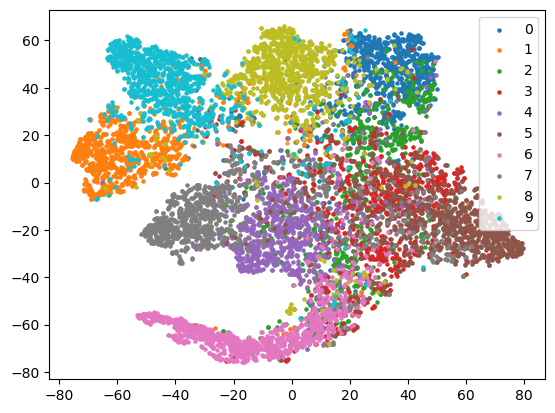

In [140]:
for i in range(num_classes):
    plt.scatter(tfeats[labels == i,0], tfeats[labels==i, 1], cmap='tab10', s=5, label=i)
plt.legend()
plt.show()